In [28]:
import os
import logging
import warnings
import pandas as pd
import numpy as np
import itertools
from tqdm.notebook import tqdm

from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

logging.getLogger("prophet").setLevel(logging.WARNING)
logging.getLogger("cmdstanpy").disabled=True
warnings.filterwarnings("ignore")  # Ignoring warnings to reduce text spam.

class forecaster():
    # Data retrieval function.
    def retrieve_data():
        os.chdir('..')
        cwd = os.getcwd()
        if 'data' in os.listdir():
            os.chdir(cwd + '\\data')
            df = pd.read_csv('data.csv', sep=';', decimal=',')
            df['ds'] = pd.to_datetime(df[['year','month']].assign(day=1))
            df['y'] = df['quantity'].round().astype('int64')
            df.drop(columns=['year','month','quantity'], inplace=True)
            return df
    
    # Model fitting.
    def fit_predict_model(
        dataframe,
        changepoint_prior_scale=0.05,
        seasonality_prior_scale=10,
        changepoint_range = 0.8,
        periods=60):

        m = Prophet(
            daily_seasonality = False, 
            yearly_seasonality = True, 
            weekly_seasonality = False,
            seasonality_mode = 'multiplicative',
            changepoint_range = changepoint_range,
            changepoint_prior_scale=changepoint_prior_scale,
            seasonality_prior_scale=seasonality_prior_scale
        )

        m = m.fit(dataframe)
        future = m.make_future_dataframe(periods=periods, freq='MS', include_history=True)

        forecast = m.predict(future)
        forecast['fact'] = dataframe['y'].reset_index(drop = True)
        return forecast, m
    
    # Plot predictions.
    def plot_prediction(model, prediction):
        model.plot(prediction)

    # anomalous data detection function. Works on prophet confidence intervals.
    def detect_anomalies(forecast):
        forecasted = forecast[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact']].copy()
        forecasted['anomaly'] = 0
        forecasted.loc[forecasted['fact'] > forecasted['yhat_upper'], 'anomaly'] = 1
        forecasted.loc[forecasted['fact'] < forecasted['yhat_lower'], 'anomaly'] = -1

        #anomaly importances
        forecasted['importance'] = 0
        forecasted.loc[forecasted['anomaly'] ==1, 'importance'] = (forecasted['fact'] - forecasted['yhat_upper'])/forecast['fact']
        forecasted.loc[forecasted['anomaly'] ==-1, 'importance'] = (forecasted['yhat_lower'] - forecasted['fact'])/forecast['fact']

        return forecasted

    # Evaluates the prophet model using mdape, mape and smape metrics.
    def evaluate_model(model):
        df_cv = cross_validation(
        model, 
        initial='731 days', 
        horizon='365 days',
        period='365 days',
        parallel = 'processes')
        df_p = performance_metrics(df_cv, monthly=True)
        mdape = df_p['mdape'].mean()
        mape = df_p['mape'].mean()
        smape = df_p['smape'].mean()
        print(f'MAPE: {mape:.3%}\nMDAPE: {mdape:.3%}\nSMAPE: {smape:.3%}')
    
    # Removes anomalies from a dataframe. use the dataframe generated from detect_anomalies().
    def remove_anomalies(df, forecast):
        anomaly_list = forecast[forecast['anomaly'] != 0]['ds']
        return df[~df['ds'].isin(anomaly_list)]
    
    # Hyper tuning the dataframe.
    def hyper_tuner(dataframe, params):
        all_params = [dict(zip(params.keys(), v)) for v in itertools.product(*param_grid.values())]
        metrics = [[],[],[]] # Storing metrics into separate arrays.

        # Use cross validation to evaluate all parameters
        for params in tqdm(all_params):
            m = Prophet(**params).fit(dataframe)  # Fit model with given params
            df_cv = cross_validation(m, initial='731 days', horizon='365 days', period='365 days', parallel = 'processes')
            df_p = performance_metrics(df_cv,monthly=True)
            metrics[0].append(df_p['mdape'].values[0])
            metrics[1].append(df_p['mape'].values[0])
            metrics[2].append(df_p['smape'].values[0])
            
        # Placing performance metrics into a dataframe.
        tuning_results = pd.DataFrame(all_params)
        tuning_results['mdape'] = metrics[0]
        tuning_results['mape'] = metrics[1]
        tuning_results['smape'] = metrics[2]
        # Applying weights and using mape as the critical error metric.
        tuning_results['performance index'] = (tuning_results['mdape']*0.2) + (tuning_results['mape']*0.6) + (tuning_results['smape']*0.2)
            
        best_param = all_params[np.argmin(tuning_results['performance index'])]
        return best_param

In [9]:
df = forecaster.retrieve_data()

In [10]:
f, m = forecaster.fit_predict_model(df)

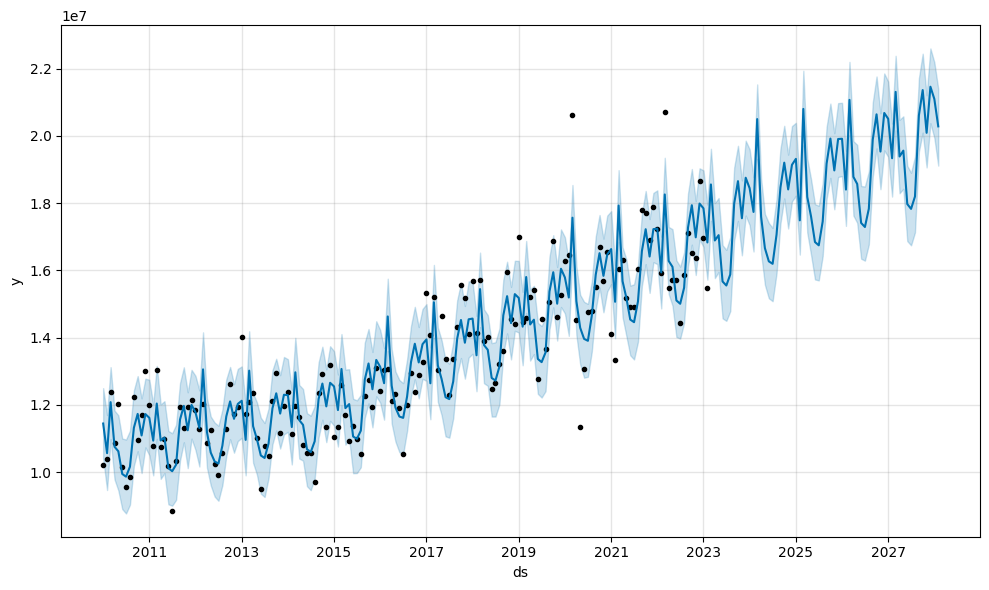

In [11]:
forecaster.plot_prediction(m, f)

In [13]:
a = forecaster.detect_anomalies(f)

In [17]:
forecaster.evaluate_model(m)

MAPE: 6.986%
MDAPE: 5.302%
SMAPE: 6.939%


In [20]:
dfc = forecaster.remove_anomalies(df, a)

In [31]:
param_grid = {
    'changepoint_prior_scale':[0.01,0.1,0.25,0.5],
    'seasonality_prior_scale':[0.01,0.1,0.5,1.0,5.0,10.0],
    'changepoint_range':[0.8,0.95]
}
params = forecaster.hyper_tuner(dfc,param_grid)

  0%|          | 0/48 [00:00<?, ?it/s]

In [30]:
params

{'changepoint_prior_scale': 0.25,
 'seasonality_prior_scale': 0.01,
 'changepoint_range': 0.8}